# Début d'implémentation du modèle

### Étape 0 : Importations

In [122]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import math
import pandas as pd
import random

### Étape 1 : Récupération des données

In [123]:
df = pd.read_csv("W:/Documents/StatApp/Github/StatApp/data/sample_3.txt",sep='\n',header=None)

### Étape 2 : Créer le vocabulaire à partir du corpus de phrases

In [124]:
df2 = df[0:10000]

corpus = []
for index, row in df2.iterrows():
    for j, column in row.iteritems():
        corpus.append(column)
        
#Resultats
print(df2[2:4])

                                                   0
2                                  Il est 1 heure . 
3  Eeeeh jfais la go qui a de les programmes mais...


In [125]:
corpus_corr = []

for phrase in corpus:
    # Suppression de la ponctuation
    phrase = phrase.replace("?","")
    phrase = phrase.replace(".","")
    phrase = phrase.replace("!","")
    phrase = phrase.replace(";","")
    phrase = phrase.replace(",","")
    phrase = phrase.replace(":","")
    phrase = phrase.replace("#","")                            
                            
    # On met tout en minuscule
    phrase = phrase.lower()
    # On ajoute la phrase
    corpus_corr.append(phrase)
    
#Resultats    
print(corpus_corr[2:4])

['il est 1 heure  ', 'eeeeh jfais la go qui a de les programmes mais j’ ai même pas de navigo ptdddddr 😭 ']


In [126]:
def tokenize(corpus):
    tokens = [phrase.split() for phrase in corpus]
    return tokens

t_corpus = tokenize(corpus_corr)

#Resultats
print(t_corpus[2:4])

[['il', 'est', '1', 'heure'], ['eeeeh', 'jfais', 'la', 'go', 'qui', 'a', 'de', 'les', 'programmes', 'mais', 'j’', 'ai', 'même', 'pas', 'de', 'navigo', 'ptdddddr', '😭']]


In [127]:
# On remplace les @nicknames
phrase_corr = []
corpus_corr2 = []
for phrase in t_corpus:
    for mot in phrase:
        if mot[0] == '@':
           mot = "@nickname"
        phrase_corr.append(mot)
    corpus_corr2.append(phrase_corr)
    phrase_corr = []
   
t_corpus = corpus_corr2

#Resultats
print(t_corpus[1:10])

[['@nickname', 'et', 'fière', 'je', "t'", "en'", 'voi', 'att', "j'", 'avais', 'oublié'], ['il', 'est', '1', 'heure'], ['eeeeh', 'jfais', 'la', 'go', 'qui', 'a', 'de', 'les', 'programmes', 'mais', 'j’', 'ai', 'même', 'pas', 'de', 'navigo', 'ptdddddr', '😭'], ['en', 'tout', 'cas', 'la', 'demoiselle', 'a', 'bien', 'raison'], ['le', 'rathalos', 'est', 'un', 'gros', 'fils', 'de', 'pute', 'bonne', 'nuit'], ['@nickname', 'et', 'puis', 'un', 'jour', 'pfffffffffus', 'rien', 'ne', 'fonctionne', 'l’', 'humain', 'se', 'meurt', 'à', 'petit', 'feu'], ['@nickname', 'je', 'veux', 'pas', '+', 'en', 'savoir', 'sasuke', '(', 'j’', 'sais', 'pas', 'qui', 'c’', 'est', 'mais', 'j’', 'crois', 'il', 'est', 'sombre', ')'], ['à', 'partir', 'de', 'quand', 'peut', '-on', 'se', 'qualifier', 'de', 'fan'], ['go', 'profité', 'de', 'les', '6h20', 'de', 'sommeil', "qu'", 'il', 'me', 'reste']]


In [128]:
voc = []
freqs = {}
for phrase in t_corpus:
    for mot in phrase:
        if mot not in voc:
            voc.append(mot)
            freqs[mot] = 1
        else:
            freqs[mot] +=1
voc_size = len(voc)

#Resultats
print("Il y a ", len(freqs), "mots DIFFERENTS dans le corpus.")
for cle, valeur in list(freqs.items())[0:3]:
    print("La clé {} contient la valeur {}.".format(cle, valeur))
    
    

Il y a  13598 mots DIFFERENTS dans le corpus.
La clé il contient la valeur 860.
La clé mérite contient la valeur 10.
La clé d’ contient la valeur 276.


###### Calcul des probas pour le subsampling et le negative sampling

In [129]:
total_mots = 0
for phrase in t_corpus:
    total_mots += len(phrase)
    
#Resultats
print("Il y a", total_mots, "mots EN TOUT dans le corpus.")

Il y a 112688 mots EN TOUT dans le corpus.


In [130]:
for key, value in freqs.items():
    freqs[key] = value / total_mots

#Resultats
for cle, valeur in list(freqs.items())[0:3]:
    print("La clé {} contient la valeur {}.".format(cle, valeur)) 

La clé il contient la valeur 0.007631691040749681.
La clé mérite contient la valeur 8.87405934970893e-05.
La clé d’ contient la valeur 0.002449240380519665.


In [131]:
# Probabilité d'être gardé dans le subsampling
p_sub = {word: min((math.sqrt(freqs[word]/0.001)+1)*(0.001/freqs[word]),1) for word in freqs}

#Resultats
for cle, valeur in list(p_sub.items())[0:3]:
    print("La clé {} contient la valeur {}.".format(cle, valeur))

La clé il contient la valeur 0.49301675411987717.
La clé mérite contient la valeur 1.
La clé d’ contient la valeur 1.


In [135]:
#negative sampling 
p_neg_1 = {word: freqs[word]**(3/4) for word in freqs}
total_neg = 0
for word in p_neg_1:
    total_neg+=p_neg_1[word]
p_neg = {word: p_neg_1[word]/total_neg for word in p_neg_1}

#Resultats
for cle, valeur in list(p_neg.items())[0:3]:
    print("La clé {} contient la valeur {}.".format(cle, valeur))

La clé il contient la valeur 0.0038444199610177076.
La clé mérite contient la valeur 0.0001361309844213106.
La clé d’ contient la valeur 0.0016392258595599853.


In [121]:
#On commence à avoir un peu d'aléa a partir de maintenant donc on fixe la graine pour voir...
#np.random.seed(0)

#On ne garde que les mots les moins fréquents dans notre échantillon d'entraînement. 
#train_words = [word for word in voc if np.random.random() < (p_drop[word])]
#voc_size = len(train_words)

#Resultats
#print("Il y a",len(train_words),"mots d'entrainement")
#print(train_words[1:10])

#corpus_samp = []
#for phrase in t_corpus:
#    phrase_samp = []
#    for mot in phrase:
#        if mot in train_words:
#            phrase_samp.append(mot)
#    corpus_samp.append(phrase_samp)

#Resultats
#print("Premier élément ancien corpus : ")
#print(t_corpus[0])
#print("Premier élément corpus nettoyé après sub sampling : ")
#print(corpus_samp[0])


### Étape 3 : Créations pairs mots centraux / contexte

In [136]:
mot_index = {w: index for (index, w) in enumerate(voc)}
index_mot = {index: w for (index, w) in enumerate(voc)}

taille_fenetre = 4
index_pairs = []
# On traite chaque phrase.
for phrase in t_corpus:
    indices = [mot_index[mot] for mot in phrase]
    # On traite chaque mot comme un mot central
    for center_word in range(len(indices)):
        # Pour chaque fenetre possible
        for w in range(-taille_fenetre, taille_fenetre + 1):
            context_word = center_word + w
            # On fait attention à ne pas sauter de phrases
            if context_word < 0 or context_word >= len(indices) or center_word == context_word:
                continue
            context_word_ind = indices[context_word]
            index_pairs.append((indices[center_word], context_word_ind))

index_pairs_np = np.array(index_pairs)

In [137]:
#Resultats
print("Contenu de mot_index : ")
for cle, valeur in list(mot_index.items())[:1]:
    print("le mot {} a pour index {}.".format(cle, valeur))
print("\nContenu de index_mot : ")
for cle, valeur in list(index_mot.items())[:1]:
    print("le mot {} a pour index {}.".format(cle, valeur))
        
print("\nContenu de index_pairs : ")
print(index_pairs[1:10])
print("\nContenu de index_pairs_np : ")
print(index_pairs_np[1:10])

Contenu de mot_index : 
le mot il a pour index 0.

Contenu de index_mot : 
le mot 0 a pour index il.

Contenu de index_pairs : 
[(0, 2), (0, 3), (0, 4), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (2, 0)]

Contenu de index_pairs_np : 
[[0 2]
 [0 3]
 [0 4]
 [1 0]
 [1 2]
 [1 3]
 [1 4]
 [1 5]
 [2 0]]


### Étape 4 : Création du modèle

In [143]:
#### Attente nouvelle version Romain

#Couche d'entrée
def get_input_layer(word_idx):
    x = torch.zeros(voc_size).float()
    x[word_idx] = 1.0
    return x

# Choix de dimension
embedding_dims = 10
# Initialisation
# Variable : comme Tensor mais avec les valeurs qui changent pendant le traitement
W1 = Variable(torch.randn(embedding_dims, voc_size).float(), requires_grad=True)
W2 = Variable(torch.randn(voc_size, embedding_dims).float(), requires_grad=True)
num_epochs = 5 # "époques"
learning_rate = 0.01

# Différentes étapes
for epo in range(num_epochs):
    loss_val = 0
    for word, context in index_pairs[1:1000]: #####ATTENTION A ENLEVER le [1:X]
        x = Variable(get_input_layer(word)).float()
        y_true = Variable(torch.from_numpy(np.array([context])).long())

        # Matmul = produits matriciels de deux tensors
        z1 = torch.matmul(W1, x)
        z2 = torch.matmul(W2, z1)
    
        # Calcul softmax
        log_softmax = F.log_softmax(z2, dim=0)
        
        # nll_loss(pred/target) - negative log likehood
        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        loss_val += loss.data
        
        # Propagation
        loss.backward()
        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()

In [144]:
#Resultats 
print(W1[0:1])
print(W2[0:1])

tensor([[-6.0528e-01, -1.2635e+00,  3.0218e-01,  ...,  6.6287e-01,
          8.2751e-01,  4.4524e-01]], grad_fn=<SliceBackward>)
tensor([[ 0.2965,  1.1058,  0.8936,  0.6576, -0.7671, -0.5915, -0.0362,  0.2257,
          0.1649, -0.7519]], grad_fn=<SliceBackward>)


In [145]:
# Distance/similarité cosinus
def cos_distance(u, v):
    return (np.dot(u, v)  / (math.sqrt(np.dot(u, u)) *  (math.sqrt(np.dot(v, v)))))

In [146]:
# Dictionnaire des poids
mot_poids = {index_mot[index]: poids.detach().numpy() for (index, poids) in enumerate(W2)}

In [147]:
print("Il y a ",len(mot_poids),"mots avec des vecteurs de poids associés\n")

for cle, valeur in list(mot_poids.items())[:1]:
    print("le mot {} a pour poids {}.".format(cle, valeur))


Il y a  13598 mots avec des vecteurs de poids associés

le mot il a pour poids [ 0.2965326   1.1058315   0.89360094  0.65762323 -0.7670584  -0.59147245
 -0.03616745  0.22572127  0.16494267 -0.7518937 ].


### Étape 5 : Résultats du modèle

In [148]:
def mot_plus_proche(word, n=5):
    word_distance = {}
    for mot in mot_poids:
        if mot != word:
            word_distance[mot] = (cos_distance(mot_poids[mot],(mot_poids[word])))
    word_distance = sorted(word_distance.items(), key=lambda t: t[1],reverse=True)
    return word_distance[0:n]

In [149]:
mot_test = "mérite"
mots_proches = mot_plus_proche(mot_test,5)
mots_proches

[('allergie', 0.8833609088141965),
 ('lb', 0.8788200115148704),
 ('cacher', 0.8534179778559605),
 ('winston', 0.8523046428187754),
 ('tôt🔥', 0.8493962930293477)]

### Étape 6 : Data visualisation

In [150]:
import pandas as pd
df = pd.DataFrame.from_dict(mot_poids).transpose()
df['label'] = 'Autre' 

df.loc[mot_test,'label'] = 'Exemple 1 Target'

for i in range(0,len(mots_proches)):
    df.loc[mots_proches[i][0],'label'] = 'Exemple 1 Contexte'

df.head(3)

,0,1,2,3,4,5,6,7,8,9,label
il,0.296533,1.105832,0.893601,0.657623,-0.767058,-0.591472,-0.036167,0.225721,0.164943,-0.751894,Autre
mérite,0.973640,1.765254,-0.155052,-1.465432,-1.313222,0.084430,0.585301,2.863036,-0.775647,1.898356,Exemple 1 Target
d’,0.497566,-0.459737,0.070080,-1.624784,-0.880588,-0.181245,-0.210444,-0.018964,1.576706,1.437540,Autre


In [151]:
from sklearn.preprocessing import StandardScaler
features = [0, 1, 2, 3, 4, 5, 6, 7,8 ,9]
# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['label']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [152]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Axe 1', 'Axe 2'])
principalDf.head(2)

,Axe 1,Axe 2
0,0.060550,-0.171921
1,0.506523,2.310219


In [153]:
df['mot'] = df.index.values
df = df.reset_index()
df[['label','mot']].head(10)

,label,mot
0,Autre,il
1,Exemple 1 Target,mérite
2,Autre,d’
3,Autre,être
4,Autre,bloquer
5,Autre,la
6,Autre,lettre
7,Autre,de
8,Autre,l’
9,Autre,alphabet


In [154]:
finalDf = pd.concat([principalDf, df[['label','mot']]],  axis = 1)
finalDf.head(5)

,Axe 1,Axe 2,label,mot
0,0.060550,-0.171921,Autre,il
1,0.506523,2.310219,Exemple 1 Target,mérite
2,-0.566153,-0.523209,Autre,d’
3,-1.422401,1.238289,Autre,être
4,1.527533,0.920057,Autre,bloquer


In [155]:
pca.explained_variance_ratio_

array([0.10472406, 0.10308717], dtype=float32)

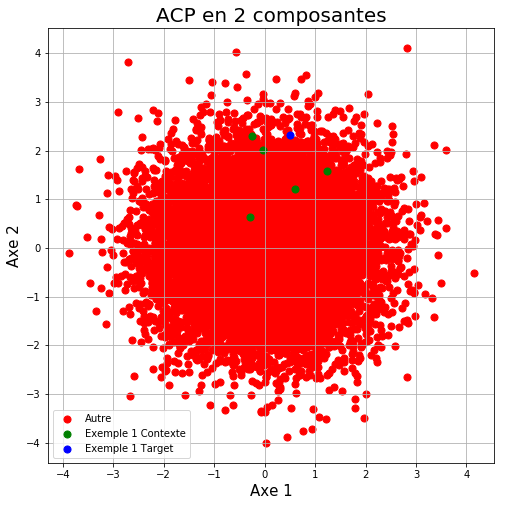

In [156]:
# Représentation simple statique 
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Axe 1', fontsize = 15)
ax.set_ylabel('Axe 2', fontsize = 15)
ax.set_title('ACP en 2 composantes', fontsize = 20)
targets = list(set(df['label']))
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'Axe 1']
               , finalDf.loc[indicesToKeep, 'Axe 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [157]:
# Représentation interactive 

import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#Travailler avec sous-table sinon trop lourd
subFinalDf = pd.concat([finalDf[(finalDf['label'] != "Autre")],finalDf.iloc[1:100:]],  axis = 0)


subFinalDf.iplot(kind='scatter',
              mode='markers',
              x='Axe 1',
              y='Axe 2',
              categories='label',
              text='mot',
              xTitle='Axe 1',
              yTitle='Axe 2',
              title='ACP en 2 composantes',
              filename='cufflinks/simple-scatter')